<a href="https://colab.research.google.com/github/ttezy/Time-Sequence-Analysis/blob/main/2.2.%20LSTM_Multivariate_traffic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Step 1: Load data**
## **You may need to upload Metro_Interstate_Traffic_Volume.csv to /content/Metro_Interstate_Traffic_Volume.csv**

## **Import libs**

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from numpy import concatenate
from math import sqrt

## **Load dataset**

In [ ]:
df=pd.read_table('Metro_Interstate_Traffic_Volume.csv',header=0, index_col=['date_time'], sep=',', error_bad_lines=False).dropna()
df

b'Skipping line 15578: expected 9 fields, saw 12\n'


holiday    temp  ...  weather_description  traffic_volume
date_time                            ...                                     
2012-10-02 09:00:00    None  288.28  ...     scattered clouds          5545.0
2012-10-02 10:00:00    None  289.36  ...        broken clouds          4516.0
2012-10-02 11:00:00    None  289.58  ...      overcast clouds          4767.0
2012-10-02 12:00:00    None  290.13  ...      overcast clouds          5026.0
2012-10-02 13:00:00    None  291.14  ...        broken clouds          4918.0
...                     ...     ...  ...                  ...             ...
2017-02-23 21:00:00    None  271.87  ...     scattered clouds          2716.0
2017-02-23 22:00:00    None  271.84  ...      overcast clouds          1956.0
2017-02-23 23:00:00    None  271.72  ...      overcast clouds          1135.0
2017-02-24 00:00:00    None  271.62  ...           light snow           696.0
2017-02-24 01:00:00    None  271.29  ...           light snow           338.0

[48202 rows x 8 columns]

## **Check if exist Null**

In [ ]:
df.isnull().sum()

holiday                0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
traffic_volume         0
dtype: int64

## **Check which attribute is not the float**

In [ ]:
df.dtypes

holiday                 object
temp                    object
rain_1h                float64
snow_1h                float64
clouds_all             float64
weather_main            object
weather_description     object
traffic_volume         float64
dtype: object

## **Reformat value to float**

In [ ]:
df['temp'] = df['temp'].astype(float)
df.dtypes

holiday                 object
temp                   float64
rain_1h                float64
snow_1h                float64
clouds_all             float64
weather_main            object
weather_description     object
traffic_volume         float64
dtype: object

## **Encode 'holiday', 'weather_main', 'weather_description'**

In [ ]:
encoder = LabelEncoder()
df['holiday'] = encoder.fit_transform(df['holiday']).astype(float)
df['weather_main'] = encoder.fit_transform(df['weather_main']).astype(float)
df['weather_description'] = encoder.fit_transform(df['weather_description']).astype(float)
df.head()

holiday    temp  ...  weather_description  traffic_volume
date_time                             ...                                     
2012-10-02 09:00:00      7.0  288.28  ...                 24.0          5545.0
2012-10-02 10:00:00      7.0  289.36  ...                  2.0          4516.0
2012-10-02 11:00:00      7.0  289.58  ...                 19.0          4767.0
2012-10-02 12:00:00      7.0  290.13  ...                 19.0          5026.0
2012-10-02 13:00:00      7.0  291.14  ...                  2.0          4918.0

[5 rows x 8 columns]

In [ ]:
df.dtypes

holiday                float64
temp                   float64
rain_1h                float64
snow_1h                float64
clouds_all             float64
weather_main           float64
weather_description    float64
traffic_volume         float64
dtype: object

## **Shift the last attribute(output) to the first one**

In [ ]:
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
cols

['traffic_volume',
 'holiday',
 'temp',
 'rain_1h',
 'snow_1h',
 'clouds_all',
 'weather_main',
 'weather_description']

In [ ]:
df = df[cols]
df.head()

traffic_volume  holiday  ...  weather_main  weather_description
date_time                                     ...                                   
2012-10-02 09:00:00          5545.0      7.0  ...           1.0                 24.0
2012-10-02 10:00:00          4516.0      7.0  ...           1.0                  2.0
2012-10-02 11:00:00          4767.0      7.0  ...           1.0                 19.0
2012-10-02 12:00:00          5026.0      7.0  ...           1.0                 19.0
2012-10-02 13:00:00          4918.0      7.0  ...           1.0                  2.0

[5 rows x 8 columns]

## **Visualize data**

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbb803715d0>,
      dtype=object)

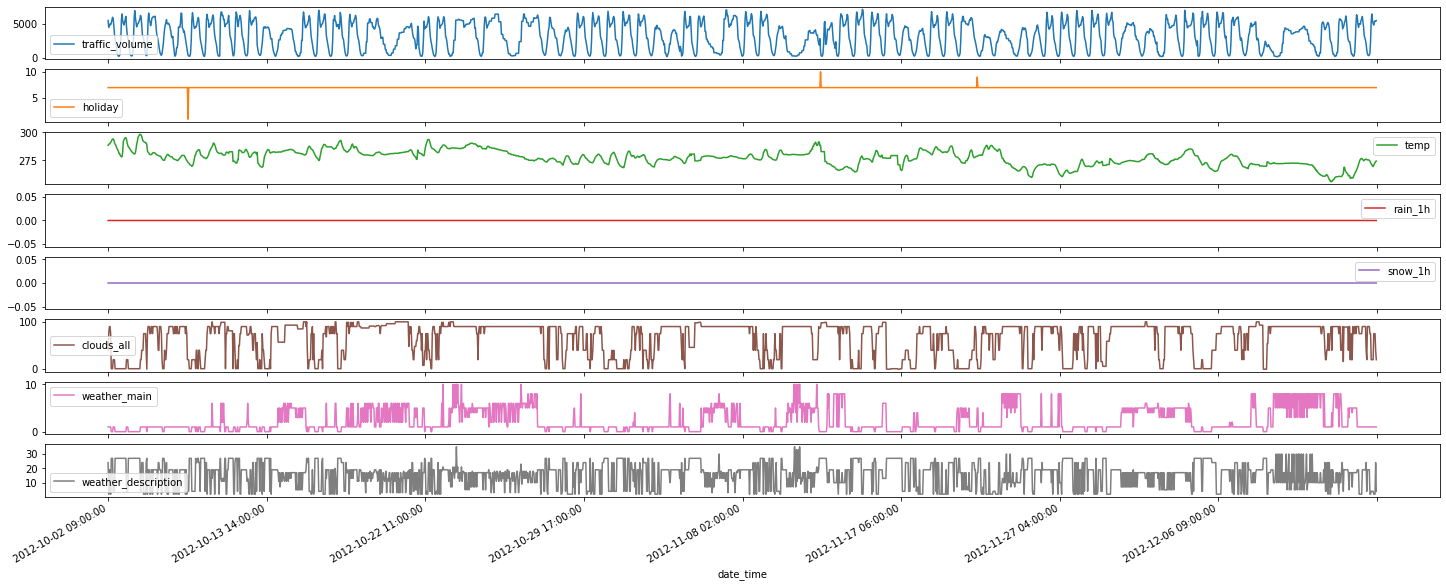

In [ ]:
df.iloc[:2000].plot(subplots=True, figsize=(25,10), legend=True)

# **Step 2: Prepare for model**

## **1 past step to predict 1 future step**





## **Normalize data values between 0 and 1**

In [ ]:
values = df.values
y_true = values[int(len(values) * 0.9):, 0] # store y_true before the data is scaled

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

## **Reframe dataset for supervised learning**

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i)[0])
        if i == 0:
            names += ['var1(t)' ]
        else:
            names += [('var1(t+%d)' % (i))]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var7(t-1)  var8(t-1)   var1(t)
1   0.761676   0.636364   0.929726  ...        0.1   0.648649  0.620330
2   0.620330   0.636364   0.933209  ...        0.1   0.054054  0.654808
3   0.654808   0.636364   0.933918  ...        0.1   0.513514  0.690385
4   0.690385   0.636364   0.935692  ...        0.1   0.513514  0.675550
5   0.675550   0.636364   0.938949  ...        0.1   0.054054  0.711676

[5 rows x 9 columns]


## **Split training and testing data**

In [ ]:
# split into train and test sets
values = reframed.values

# use first 90% data to train
n_train_hours = int(len(values) * 0.9)
train = values[:n_train_hours]
test = values[n_train_hours:]

# split into input and output (var(t-1), var1(t))
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print("train_X shape: ", train_X.shape, " train_y shape: ", train_y.shape,
      "\ntest_X shape: ", test_X.shape, " test_y shape: ", test_y.shape)

train_X shape:  (43380, 1, 8)  train_y shape:  (43380,) 
test_X shape:  (4821, 1, 8)  test_y shape:  (4821,)


# **Step 3: Train LSTM(Long Short-term Memory) model**

## **Design network**

In [ ]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

## **Fit model**

In [ ]:
epochs = 50 # modify here to choose training epoches
history = model.fit(train_X, train_y, epochs=epochs, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
603/603 - 23s - loss: 0.1056 - val_loss: 0.0674
Epoch 2/50
603/603 - 2s - loss: 0.0738 - val_loss: 0.0664
Epoch 3/50
603/603 - 2s - loss: 0.0736 - val_loss: 0.0665
Epoch 4/50
603/603 - 2s - loss: 0.0734 - val_loss: 0.0660
Epoch 5/50
603/603 - 2s - loss: 0.0735 - val_loss: 0.0663
Epoch 6/50
603/603 - 1s - loss: 0.0733 - val_loss: 0.0662
Epoch 7/50
603/603 - 1s - loss: 0.0732 - val_loss: 0.0669
Epoch 8/50
603/603 - 1s - loss: 0.0735 - val_loss: 0.0670
Epoch 9/50
603/603 - 1s - loss: 0.0733 - val_loss: 0.0661
Epoch 10/50
603/603 - 1s - loss: 0.0733 - val_loss: 0.0668
Epoch 11/50
603/603 - 1s - loss: 0.0734 - val_loss: 0.0669
Epoch 12/50
603/603 - 1s - loss: 0.0734 - val_loss: 0.0669
Epoch 13/50
603/603 - 1s - loss: 0.0732 - val_loss: 0.0666
Epoch 14/50
603/603 - 2s - loss: 0.0732 - val_loss: 0.0665
Epoch 15/50
603/603 - 2s - loss: 0.0733 - val_loss: 0.0667
Epoch 16/50
603/603 - 1s - loss: 0.0731 - val_loss: 0.0665
Epoch 17/50
603/603 - 2s - loss: 0.0731 - val_loss: 0.0670
Epoch

## **Show the training loss and test loss**

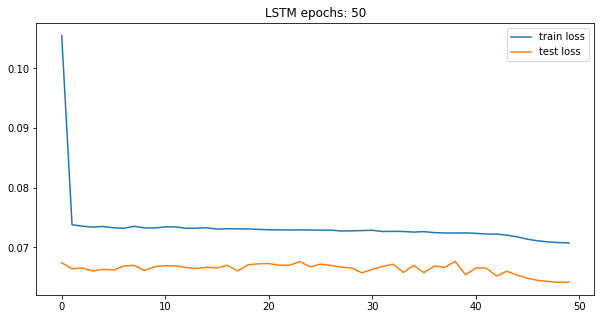

In [ ]:
# plot history
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.title("LSTM epochs: " + str(epochs))
plt.legend()
plt.show()

# **Step 4: Implement Data Forecasting**

## **Predict future 1-step data based on past 1-step data**

In [ ]:
yhat = model.predict(test_X)

## **inverse transform the prediction and the test_y**

In [ ]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

## **Calculate RMSE**

In [ ]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 754.657


## **Show first 200 predictions**

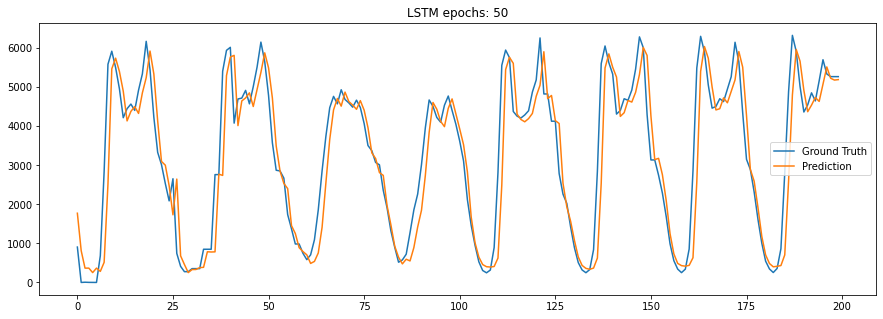

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(inv_y[:200], label='Ground Truth')
plt.plot(inv_yhat[:200], label='Prediction')
plt.title("LSTM epochs: " + str(epochs))
plt.legend()
plt.show()

## **Show first 2000 predictions**

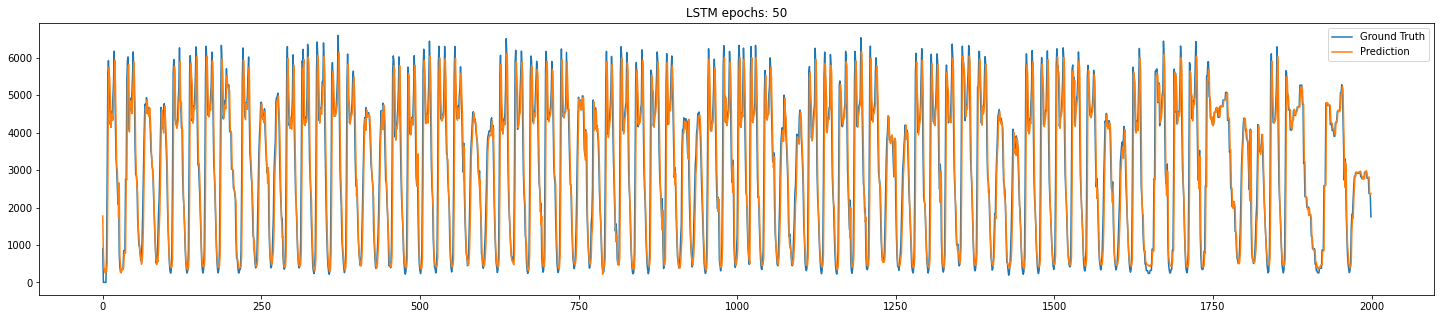

In [ ]:
plt.figure(figsize=(25, 5))
plt.plot(inv_y[:2000], label='Ground Truth')
plt.plot(inv_yhat[:2000], label='Prediction')
plt.title("LSTM epochs: " + str(epochs))
plt.legend()
plt.show()

# **Step 5: Test forecasting ability for more future time**

In [ ]:
pastStep = 24 # modify here to choose past steps
maxFutureStep = 24  # modify here to choose future steps
epochs = 50 # modify here to choose training epoches

RMSE = np.array([])
prediction = np.array([])
for futureStep in range(1, maxFutureStep+1):  # from 1 to 24
  # frame as supervised learning
  reframed = series_to_supervised(scaled, pastStep, futureStep)

  # split into train and test sets
  values = reframed.values

  # use first 90% data to train
  n_train_hours = int(len(values) * 0.9)
  train = values[:n_train_hours]
  test = values[n_train_hours:n_train_hours+4000]

  # split into input and output
  train_X, train_y = train[:, :-futureStep], train[:, -futureStep:]
  test_X, test_y = test[:, :-futureStep:], test[:, -futureStep:]

  # reshape input to be 3D [samples, timesteps, features]
  train_X_reshape = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X_reshape = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

  print("pastStep:", str(pastStep), " futureStep:%2d"%futureStep, 
        "  train X:", train_X_reshape.shape, "  train y:%12s"%str(train_y.shape), 
        "  test X:", test_X_reshape.shape, "  test y:%10s"%str(test_y.shape))
  
  # design network
  model = Sequential()
  model.add(LSTM(50, input_shape=(train_X_reshape.shape[1], train_X_reshape.shape[2])))
  model.add(Dense(futureStep))
  model.compile(loss='mae', optimizer='adam')

  model.fit(train_X_reshape, train_y, epochs=epochs, batch_size=72, validation_data=(test_X_reshape, test_y), verbose=0, shuffle=False, )

  # prediction
  result = model.predict(test_X_reshape)

  # combine prediction results
  pred = np.array([])
  for i in range(0, len(test_X), futureStep):
    pred = np.append(pred, result[i])

  pred = pred[:len(test_X)]
  y_true = y_true[:len(test_X)]

  # inverse transform prediction
  pred = pred.reshape((len(pred), 1))
  inv_pred = concatenate((pred, test_X[:, 1:8]), axis=1)
  inv_pred = scaler.inverse_transform(inv_pred)[:, 0]

  # calculate RMSE
  rmse = sqrt(mean_squared_error(y_true, inv_pred))

  RMSE = np.append(RMSE, rmse)

  if futureStep == 1:
    prediction = np.array([inv_pred])
  else:
    prediction = np.append(prediction, np.array([inv_pred]),axis = 0)

  print("prediction shape:", prediction.shape)

pastStep: 24  futureStep: 1   train X: (43360, 1, 192)   train y:  (43360, 1)   test X: (4000, 1, 192)   test y: (4000, 1)
prediction shape: (1, 4000)
pastStep: 24  futureStep: 2   train X: (43359, 1, 192)   train y:  (43359, 2)   test X: (4000, 1, 192)   test y: (4000, 2)
prediction shape: (2, 4000)
pastStep: 24  futureStep: 3   train X: (43358, 1, 192)   train y:  (43358, 3)   test X: (4000, 1, 192)   test y: (4000, 3)
prediction shape: (3, 4000)
pastStep: 24  futureStep: 4   train X: (43357, 1, 192)   train y:  (43357, 4)   test X: (4000, 1, 192)   test y: (4000, 4)
prediction shape: (4, 4000)
pastStep: 24  futureStep: 5   train X: (43356, 1, 192)   train y:  (43356, 5)   test X: (4000, 1, 192)   test y: (4000, 5)
prediction shape: (5, 4000)
pastStep: 24  futureStep: 6   train X: (43355, 1, 192)   train y:  (43355, 6)   test X: (4000, 1, 192)   test y: (4000, 6)
prediction shape: (6, 4000)
pastStep: 24  futureStep: 7   train X: (43354, 1, 192)   train y:  (43354, 7)   test X: (4000,

pastStep:  24  futureStep:   1  RMSE: 1543.785
pastStep:  24  futureStep:   2  RMSE: 1213.601
pastStep:  24  futureStep:   3  RMSE: 783.859
pastStep:  24  futureStep:   4  RMSE: 775.300
pastStep:  24  futureStep:   5  RMSE: 1042.869
pastStep:  24  futureStep:   6  RMSE: 1387.271
pastStep:  24  futureStep:   7  RMSE: 1753.979
pastStep:  24  futureStep:   8  RMSE: 1993.730
pastStep:  24  futureStep:   9  RMSE: 1985.991
pastStep:  24  futureStep:  10  RMSE: 2177.232
pastStep:  24  futureStep:  11  RMSE: 2390.791
pastStep:  24  futureStep:  12  RMSE: 2461.883
pastStep:  24  futureStep:  13  RMSE: 2620.571
pastStep:  24  futureStep:  14  RMSE: 2741.458
pastStep:  24  futureStep:  15  RMSE: 2753.922
pastStep:  24  futureStep:  16  RMSE: 2806.632
pastStep:  24  futureStep:  17  RMSE: 2864.356
pastStep:  24  futureStep:  18  RMSE: 2868.378
pastStep:  24  futureStep:  19  RMSE: 2846.944
pastStep:  24  futureStep:  20  RMSE: 2803.491
pastStep:  24  futureStep:  21  RMSE: 2752.229
pastStep:  24  

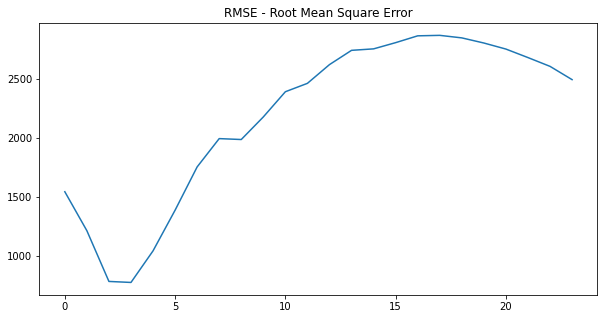

In [ ]:
for i in range(len(RMSE)):  
  print("pastStep: %3d" % pastStep, " futureStep: %3d" % (i+1), " RMSE: %.3f" % RMSE[i])

plt.figure(figsize=(10,5))
plt.plot(RMSE)
plt.title("RMSE - Root Mean Square Error")
plt.show()

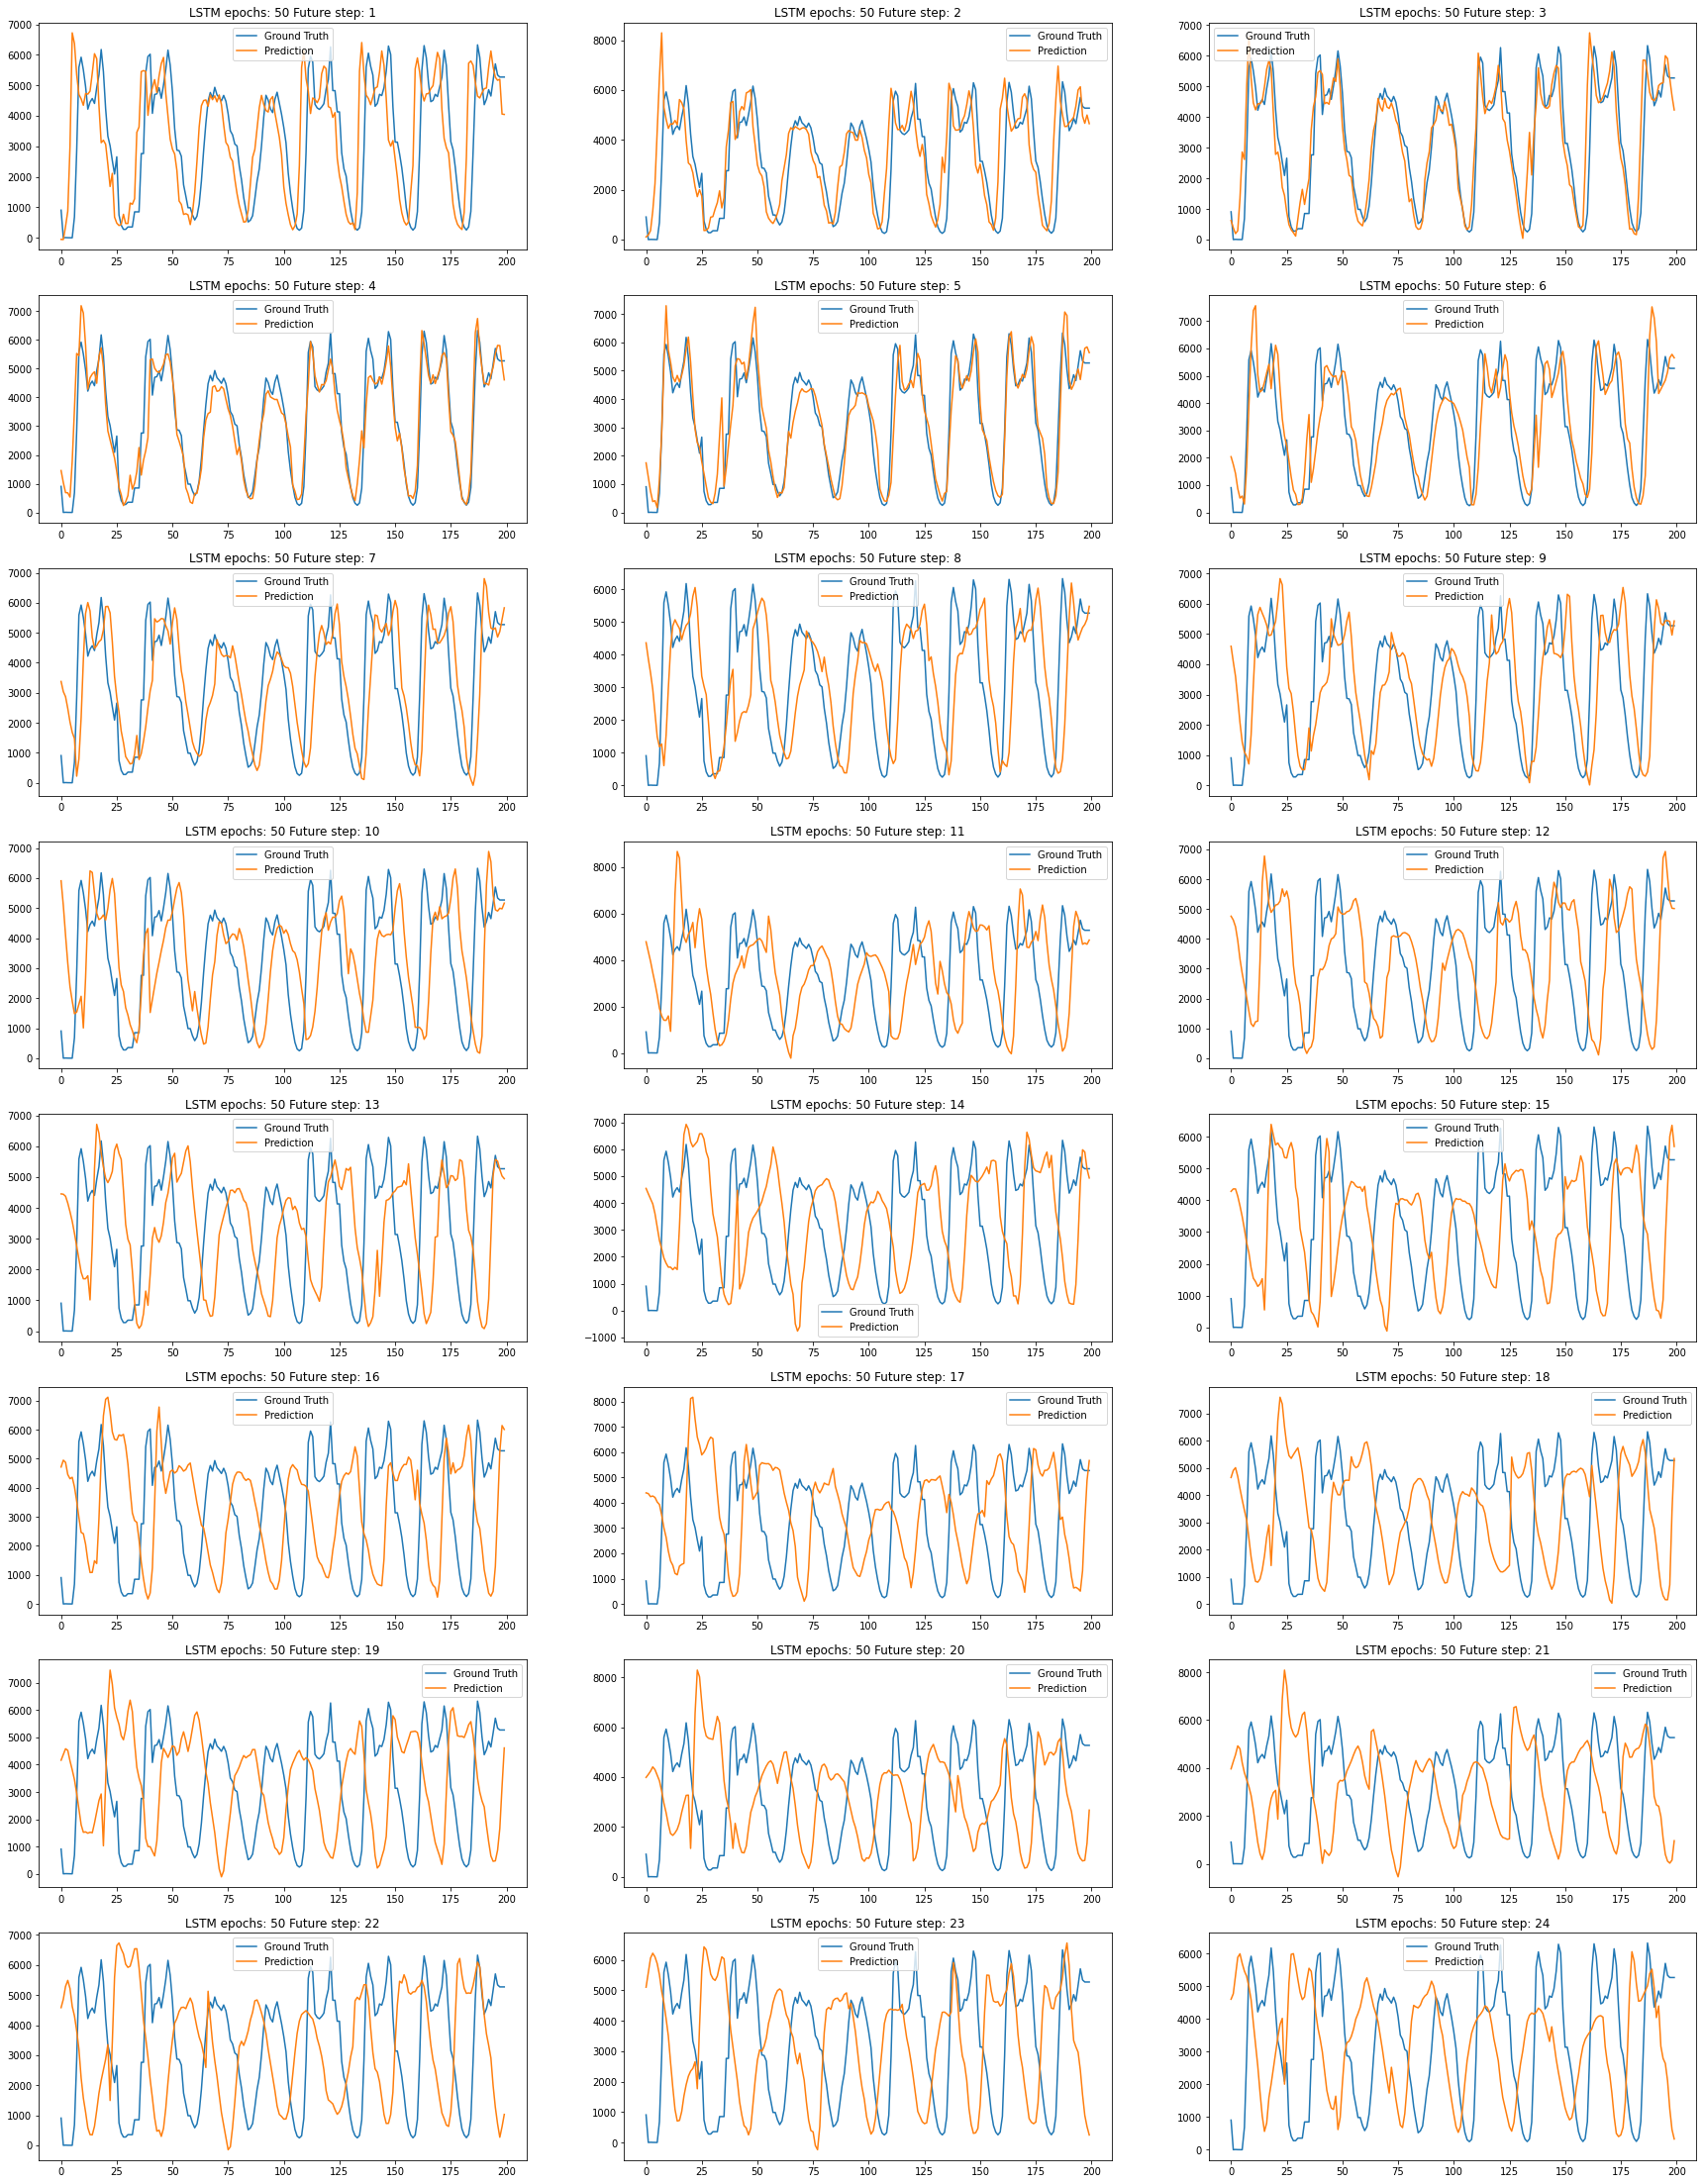

In [ ]:
plt.figure(figsize=(30,60))
for i in range(maxFutureStep):
  plt.subplot(12, 3, i+1)
  plt.plot(y_true[:200], label='Ground Truth')
  plt.plot(prediction[i][:200], label='Prediction')
  plt.title("LSTM epochs: " + str(epochs) + " Future step: " + str(i+1))
  plt.legend()
plt.show()

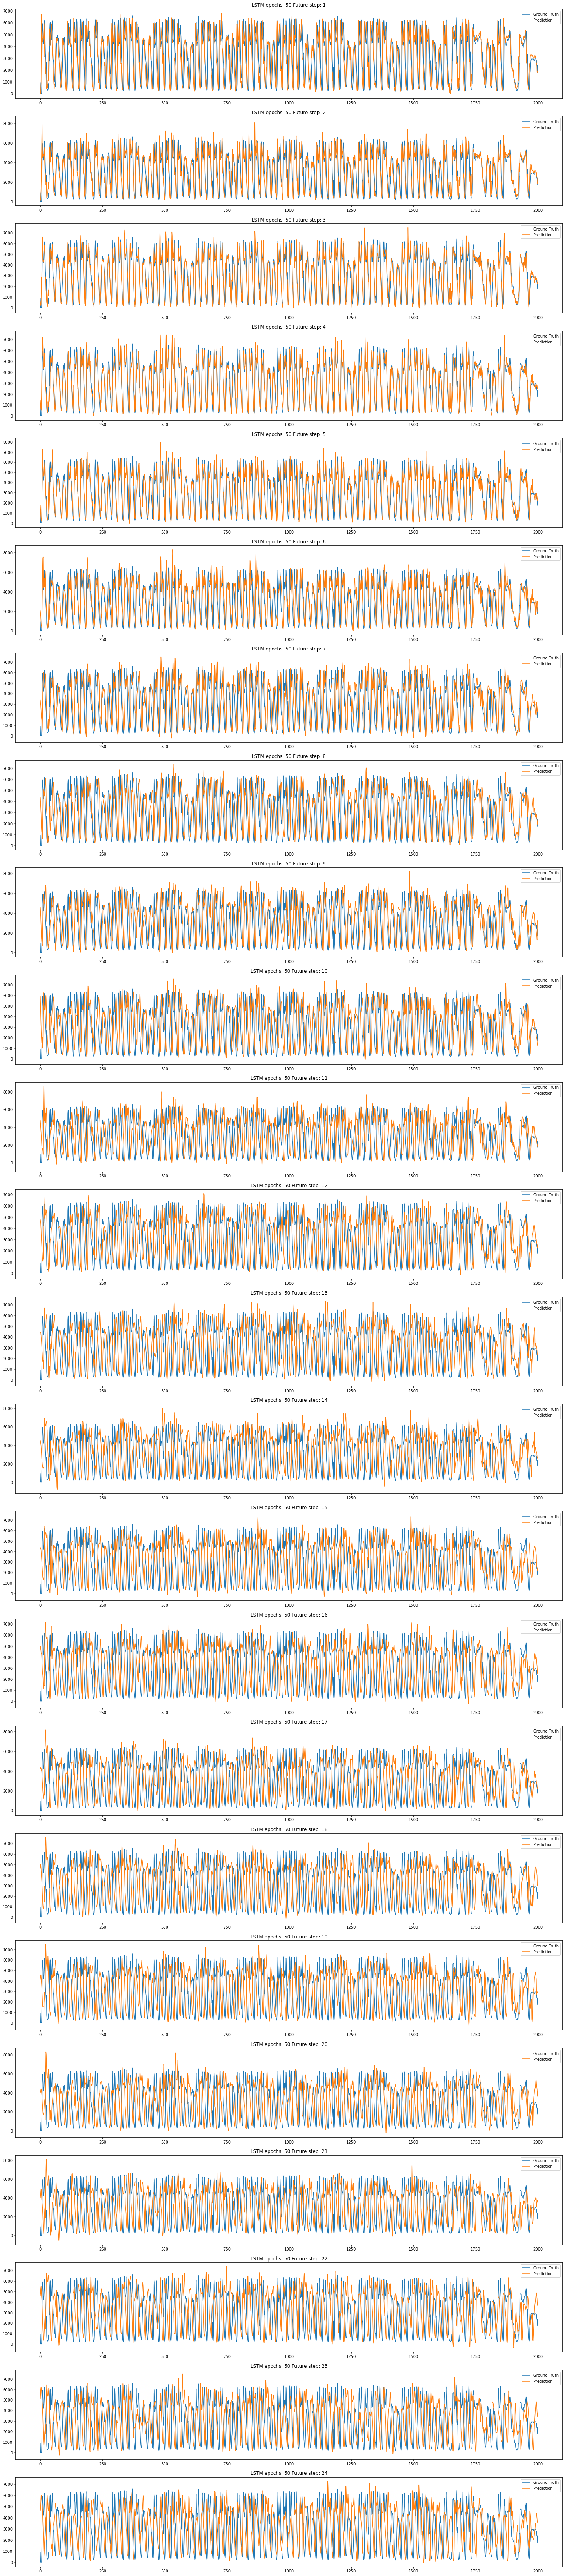

In [ ]:
plt.figure(figsize=(25, 24*5))
for i in range(maxFutureStep):
  plt.subplot(24, 1, i+1)
  plt.plot(y_true[:2000], label='Ground Truth')
  plt.plot(prediction[i][:2000], label='Prediction')
  plt.title("LSTM epochs: " + str(epochs) + " Future step: " + str(i+1))
  plt.legend()
plt.show()